In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('../data/hmeq_clean.csv')
data.drop(columns=['Unnamed: 0'],inplace=True)

In [3]:
data_cat = pd.read_csv('../data/data_0.csv')
data_cat.drop(columns=['Unnamed: 0'],inplace=True)

In [4]:
data_del_null = pd.read_csv('../data/hmeq_clean_del_null.csv')
data_del_null.drop(columns=['Unnamed: 0'],inplace=True)

In [5]:
data_del_debtinc = pd.read_csv('../data/hmeq_clean_del_debtinc.csv')
data_del_debtinc.drop(columns=['Unnamed: 0'],inplace=True)

In [6]:
data_del_null_cat = pd.read_csv('../data/data_1.csv')
data_del_null_cat.drop(columns=['Unnamed: 0'],inplace=True)

In [7]:
data_del_debtinc_cat = pd.read_csv('../data/data_2.csv')
data_del_debtinc_cat.drop(columns=['Unnamed: 0'],inplace=True)

In [8]:
data_norm_cat = pd.read_csv('../data/hmeq_normalised_cat.csv')
data_norm_cat.drop(columns=['Unnamed: 0'],inplace=True)

In [9]:
data_norm = pd.read_csv('../data/hmeq_normalised.csv')
data_norm.drop(columns=['Unnamed: 0'],inplace=True)

In [10]:
dfs = [data,data_cat,data_del_null,data_del_debtinc,data_del_null_cat,data_del_debtinc_cat]

In [11]:
y = data['BAD']

If there are any highly correlated columns I would like to delete the feature, but there are not any

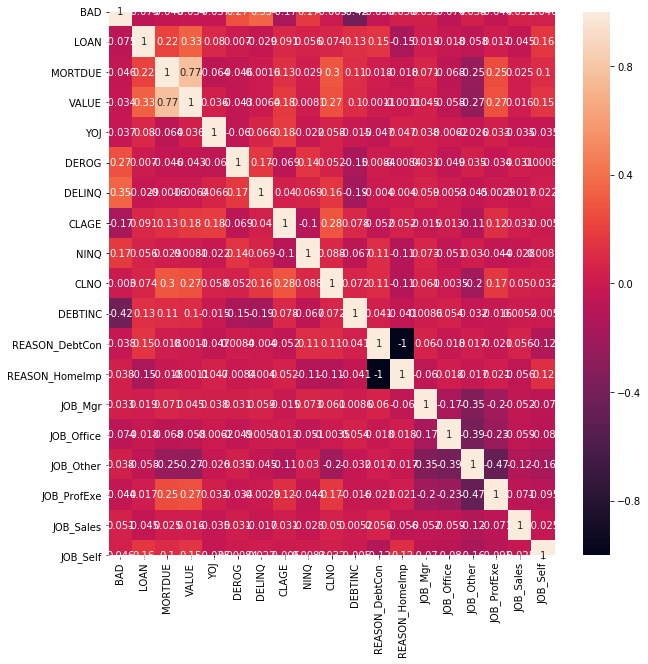

In [12]:
correlation_matrix = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=True);

In [13]:
data.isnull().sum()

BAD               0
LOAN              0
MORTDUE           0
VALUE             0
YOJ               0
DEROG             0
DELINQ            0
CLAGE             0
NINQ              0
CLNO              0
DEBTINC           0
REASON_DebtCon    0
REASON_HomeImp    0
JOB_Mgr           0
JOB_Office        0
JOB_Other         0
JOB_ProfExe       0
JOB_Sales         0
JOB_Self          0
dtype: int64

In [14]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline

pipeline = [
    StandardScaler(),
    Normalizer(),
]

def pipelinise(df):
    X = df.drop(columns=['BAD']) #FEATURE VECTOR
    tr = make_pipeline(*pipeline)
    Xpr = tr.fit_transform(X)
    dataf = pd.DataFrame(Xpr,columns=X.columns)
    dataf['BAD'] = df['BAD']
    return dataf

[dfs.append(pipelinise(dfs[i])) for i in range(6)]


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/luciasuelves/opt/anaconda3/lib/python

[None, None, None, None, None, None]

In [15]:
from sklearn.model_selection import train_test_split
"""
def split(df):
    Xpr = pipelinise(df)
    return train_test_split(Xpr,y , test_size=0.2,random_state=10)
"""
def split(df):
    return train_test_split(df.drop(columns=['BAD']),df['BAD'] , test_size=0.2,random_state=10)

In [16]:
from sklearn.linear_model import LogisticRegression

def log_reg(df):
    X_train,X_test,y_train,y_test = split(df)
    print(X_train.shape)
    model = LogisticRegression(solver="lbfgs")
    model.fit(X_train, y_train)
    return (model,X_test,y_test)

In [17]:
%matplotlib inline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def scoring(df):
    y_personalised = []
    neg = 0
    pos = 0
    model,X_test,y_test = log_reg(df)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
     
    for i in range(len(y_score)):
        if y_score[:,1][i] > 0.4:
            y_personalised.append(1)
        else:
            y_personalised.append(0)
            
    roc = roc_curve(y_test, y_personalised)        
    #roc = roc_curve(y_test, y_score[:,1])
    #display(pd.DataFrame({
    #    "predicted":y_pred,
    #    "personalised": y_personalised,
    #    "gt": y_test,
    #    "probaNotPay":y_score[:,1],
    #    "probaPay":y_score[:,0]
    #    }).head())
    plt.figure()
    plt.plot(roc[0],roc[1])
    plt.legend([f"AUC: {round(roc_auc_score(y_test, y_score[:,1]),2)}"])
    #model.predict_proba(X_test)[0]
    result = pd.DataFrame({
    "y_pred":y_pred,
    "gt":y_test
                })


    for i in range(len(y_pred)):
        if y_personalised[i] < y_test.values[i]:
            neg += 1
        elif y_personalised[i] > y_test.values[i]:
            pos += 1
            
    return (1-np.abs(y_personalised-y_test).sum()/len(y_test),1-np.abs(y_pred-y_test).sum()/len(y_test), neg/(pos+neg))

(4768, 18)
(4768, 12)
(4157, 18)


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


(4157, 17)
(4157, 12)
(4157, 11)


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


(4768, 18)
(4768, 12)
(4157, 18)
(4157, 17)
(4157, 12)
(4157, 11)


[(0.848993288590604, 0.8506711409395973, 0.5611111111111111),
 (0.848993288590604, 0.8406040268456376, 0.5333333333333333),
 (0.8634615384615385, 0.825, 0.6901408450704225),
 (0.8125, 0.8096153846153846, 0.8307692307692308),
 (0.8634615384615385, 0.8269230769230769, 0.6901408450704225),
 (0.8105769230769231, 0.8125, 0.8274111675126904),
 (0.848993288590604, 0.8540268456375839, 0.5666666666666667),
 (0.8431208053691275, 0.8431208053691275, 0.5454545454545454),
 (0.8634615384615385, 0.8711538461538462, 0.5704225352112676),
 (0.8307692307692307, 0.8221153846153846, 0.7045454545454546),
 (0.8625, 0.8673076923076923, 0.5664335664335665),
 (0.8278846153846153, 0.8163461538461538, 0.6871508379888268)]

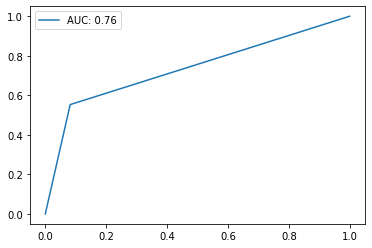

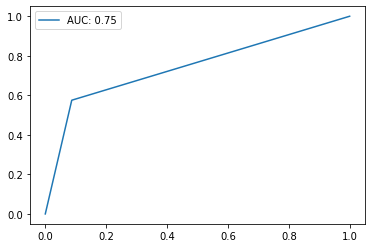

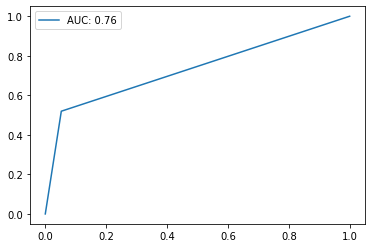

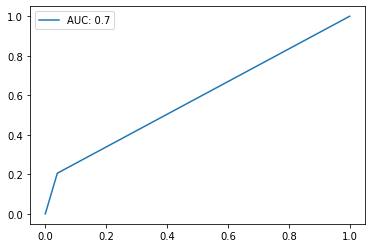

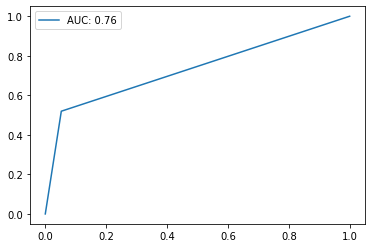

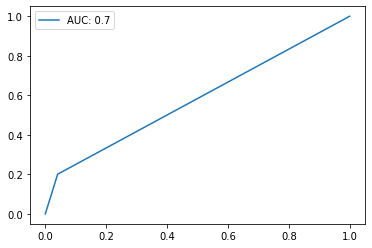

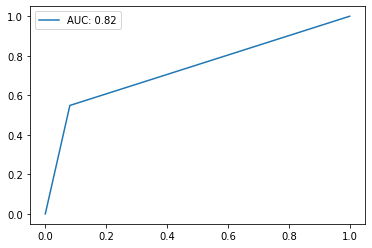

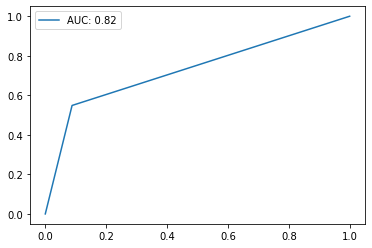

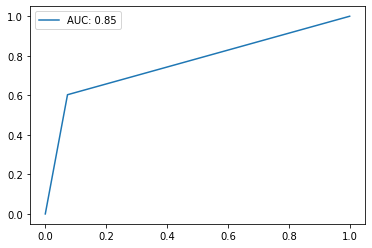

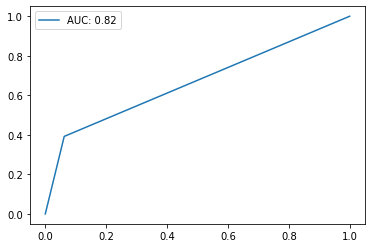

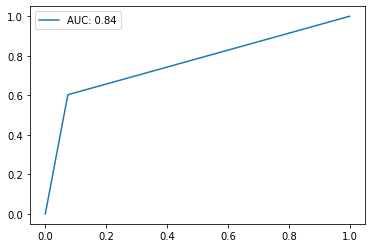

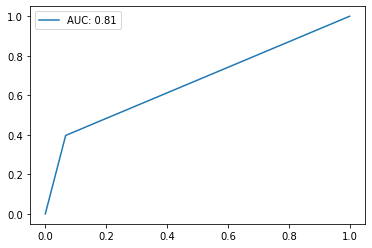

In [18]:
[scoring(df) for df in dfs]
# Hay mas errores de dar un loan a alguien que luego no paga. 
# Podemos hacer que la probabilidad que necesita a su favor sea más alta.

In the causalnex model, I need to select a limited number of features, so to choose them I could use the following

In [19]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

X = data.drop(columns=['BAD'])
featurer = SelectKBest(chi2, k=5)
X_new = featurer.fit_transform(np.abs(X), y)

In [20]:
print(X.columns[featurer.get_support()])

Index(['LOAN', 'MORTDUE', 'VALUE', 'CLAGE', 'DEBTINC'], dtype='object')


(4768, 5)


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(0.848993288590604, 0.8330536912751678, 0.55)

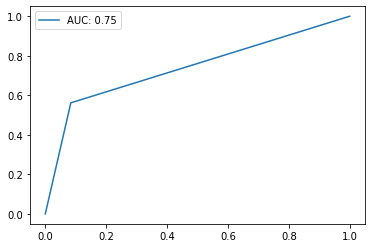

In [21]:
data_reduced = X[X.columns[featurer.get_support()]]
data_reduced['BAD'] = y
dfs.append(data_reduced)
scoring(data_reduced)

Its worse

What's worse? To give the loan and not pay or to not give the loan and pay? I have to change the percentages.

In [22]:
#I don't know

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train(df):
    X_train,X_test,y_train,y_test = split(df)
    models = {
        "logis": LogisticRegression(C=10,solver="lbfgs"),
        "svm-linear": CalibratedClassifierCV(LinearSVC(),cv=3),
        "svm-rbf": CalibratedClassifierCV(SVC(kernel="sigmoid",gamma="auto"),cv=3),
        "randomforest": RandomForestClassifier(n_estimators=200),
    }

# Train all the models in the models dict
    for name,m  in models.items():
        print(f"Training {name}...")
        m.fit(X_train, y_train)
    print("Train complete")
    

    printMetric = lambda label,value:print(f"\t {label}: {round(value,3)}")

    for name, model in models.items():
        y_pred = model.predict(X_test)
        print(f"Evaluating model {name}")
        printMetric("Accuracy",accuracy_score(y_test, y_pred))
        printMetric("Precision",precision_score(y_test, y_pred))
        printMetric("Recall",recall_score(y_test, y_pred))
        printMetric("F1Score",f1_score(y_test, y_pred))

    return("Train complete")

In [24]:
[train(df) for df in dfs]

Training logis...
Training svm-linear...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.852
	 Precision: 0.693
	 Recall: 0.389
	 F1Score: 0.499
Evaluating model svm-linear
	 Accuracy: 0.81
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model svm-rbf
	 Accuracy: 0.81
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model randomforest
	 Accuracy: 0.904
	 Precision: 0.825
	 Recall: 0.624
	 F1Score: 0.71
Training logis...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training svm-linear...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.841
	 Precision: 0.725
	 Recall: 0.257
	 F1Score: 0.379
Evaluating model svm-linear
	 Accuracy: 0.81
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model svm-rbf
	 Accuracy: 0.81
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model randomforest
	 Accuracy: 0.899
	 Precision: 0.794
	 Recall: 0.633
	 F1Score: 0.704
Training logis...
Training svm-linear...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lucia

Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.825
	 Precision: 0.775
	 Recall: 0.152
	 F1Score: 0.254
Evaluating model svm-linear
	 Accuracy: 0.804
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model svm-rbf
	 Accuracy: 0.804
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model randomforest
	 Accuracy: 0.912
	 Precision: 0.834
	 Recall: 0.691
	 F1Score: 0.756
Training logis...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lucia

Training svm-linear...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.809
	 Precision: 0.619
	 Recall: 0.064
	 F1Score: 0.116
Evaluating model svm-linear
	 Accuracy: 0.804
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model svm-rbf
	 Accuracy: 0.804
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model randomforest
	 Accuracy: 0.932
	 Precision: 0.985
	 Recall: 0.662
	 F1Score: 0.792
Training logis...
Training svm-linear...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lucia

Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.827
	 Precision: 0.786
	 Recall: 0.162
	 F1Score: 0.268
Evaluating model svm-linear
	 Accuracy: 0.804
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model svm-rbf
	 Accuracy: 0.804
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model randomforest
	 Accuracy: 0.908
	 Precision: 0.825
	 Recall: 0.672
	 F1Score: 0.741
Training logis...
Training svm-linear...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lucia

Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.807
	 Precision: 0.8
	 Recall: 0.02
	 F1Score: 0.038
Evaluating model svm-linear
	 Accuracy: 0.804
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model svm-rbf
	 Accuracy: 0.804
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model randomforest
	 Accuracy: 0.93
	 Precision: 0.971
	 Recall: 0.662
	 F1Score: 0.787
Training logis...
Training svm-linear...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.855
	 Precision: 0.693
	 Recall: 0.42
	 F1Score: 0.523
Evaluating model svm-linear
	 Accuracy: 0.843
	 Precision: 0.642
	 Recall: 0.389
	 F1Score: 0.485
Evaluating model svm-rbf
	 Accuracy: 0.839
	 Precision: 0.629
	 Recall: 0.367
	 F1Score: 0.464
Evaluating model randomforest
	 Accuracy: 0.894
	 Precision: 0.801
	 Recall: 0.588
	 F1Score: 0.679
Training logis...
Training svm-linear...
Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.843
	 Precision: 0.642
	 Recall: 0.389
	 F1Score: 0.485
Evaluating model svm-linear
	 Accuracy: 0.843
	 Precision: 0.647
	 Recall: 0.381
	 F1Score: 0.479
Evaluating model svm-rbf
	 Accuracy: 0.842
	 Precision: 0.644
	 Recall: 0.376
	 F1Score: 0.475
Evaluating model randomforest
	 Accuracy: 0.901
	 Precision: 0.838
	 Recall: 0.593
	 F1Score: 0.694
Training logis...
Training svm-linear...
Training svm-rbf...
Trainin

/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.833
	 Precision: 0.708
	 Recall: 0.204
	 F1Score: 0.316
Evaluating model svm-linear
	 Accuracy: 0.81
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model svm-rbf
	 Accuracy: 0.81
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model randomforest
	 Accuracy: 0.877
	 Precision: 0.711
	 Recall: 0.588
	 F1Score: 0.644


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


['Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete']

[       LOAN        MORTDUE          VALUE       CLAGE    DEBTINC  BAD
 0      1100   25860.000000   39025.000000   94.366667   0.000000    1
 1      1300   70053.000000   68400.000000  121.833333   0.000000    1
 2      1500   13500.000000   16700.000000  149.466667   0.000000    1
 3      1500   80013.580438   94093.914666  133.030603   0.000000    1
 4      1700   97800.000000  112000.000000   93.333333   0.000000    0
 5      1700   30548.000000   40320.000000  101.466002  37.113614    1
 6      1800   48649.000000   57037.000000   77.100000   0.000000    1
 7      1800   28502.000000   43034.000000   88.766030  36.884894    1
 8      2000   32700.000000   46740.000000  216.933333   0.000000    1
 9      2000   80013.580438   62250.000000  115.800000   0.000000    1
 10     2000   22608.000000   94093.914666  133.030603   0.000000    1
 11     2000   20627.000000   29800.000000  122.533333   0.000000    1
 12     2000   45000.000000   55000.000000   86.066667   0.000000    1
 13   